# Appendix D: Multi-class, meta-strategies

In [1]:
import sys, os
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions import *
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

- So far we have been talking about binary classification 
- Can we use these classifiers when there are more than two classes? 
    - ["ImageNet" computer vision competition](http://www.image-net.org/challenges/LSVRC/), for example, has 1000 classes 
- Can we use decision trees or KNNs for multi-class classification?
- What about logistic regression and Linear SVMs?

- Many linear classification models don't extend naturally to the multiclass case. 
- A common technique is to reduce multiclass classication into several instances of binary classification problems. 
- Two kind of "hacky" ways to reduce multi-class classification into binary classification:  
    - the one-vs.-rest approach
    - the one-vs.-one approach 

### One vs. Rest 

- 1v{2,3}, 2v{1,3}, 3v{1,2}
- Learn a binary model for each class which tries to separate that class from all of the other classes.
- If you have $k$ classes, it'll train $k$ binary classifiers, one for each class. 
- Trained on imbalanced datasets containing all examples.
- Given a test point, get scores from all binary classifiers (e.g., raw scores for logistic regression). 

- The classifier which has the highest score for this class "wins" and that's going to be the prediction for this class. 

- Since we have one binary classifier per class, we have coefficients per feature and an intercept for each class. 

```{note}
Note that there is also a multinomial logistic regression also called as **the maxent classifier**. This is different than the above multi-class meta strategies. More on this in DSCI 573. 
```

Let's create some synthetic data with two features and three classes. 

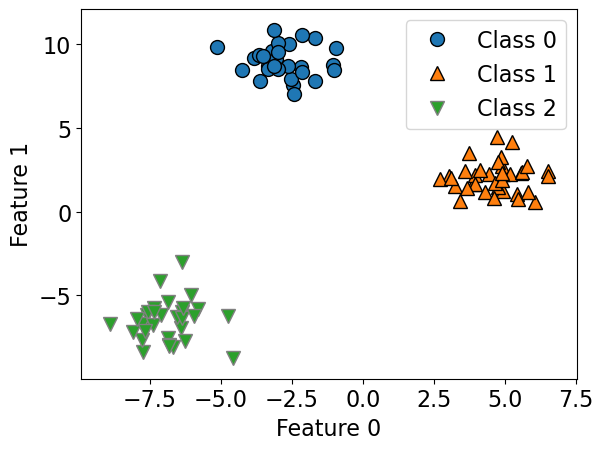

In [2]:
X, y = make_blobs(centers=3, n_samples=120, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.legend(["Class 0", "Class 1", "Class 2"]);

In [3]:

lr = LogisticRegression(max_iter=2000, multi_class="ovr")
lr.fit(X_train, y_train)
print("Coefficient shape: ", lr.coef_.shape)
print("Intercept shape: ", lr.intercept_.shape)

Coefficient shape:  (3, 2)
Intercept shape:  (3,)


/Users/kvarada/miniforge3/envs/cpsc330/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


- This learns three binary linear models.
- So we have coefficients for two features for each of these three linear models. 
- Also we have three intercepts, one for each class. 

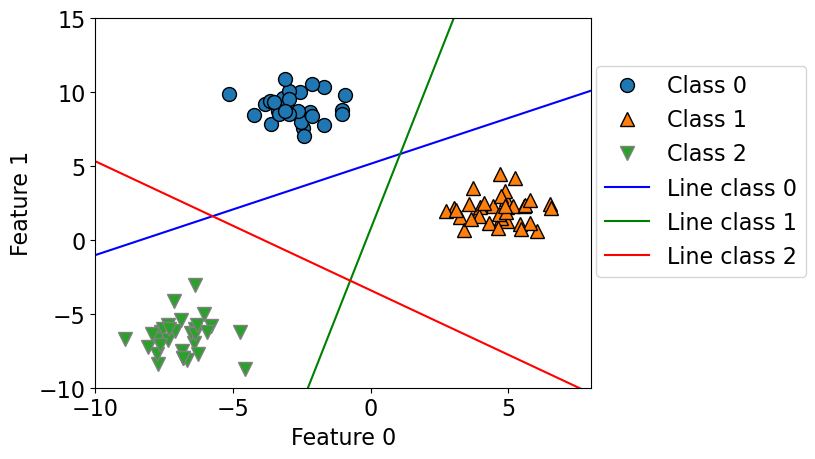

In [4]:
# Function definition in code/plotting_functions.py
plot_multiclass_lr_ovr(lr, X_train, y_train, 3)

- How would you classify the following points? 
- The answer is pick the class with the highest value for the classification formula. 

In [5]:
test_points = [[-4.0, 12], [-2, 0.0], [-8, 3.0], [4, 8.5], [0, -7]]            

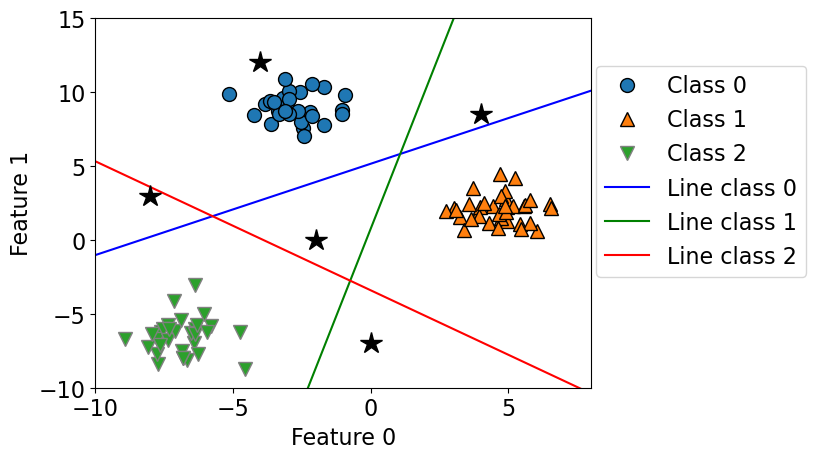

In [6]:
plot_multiclass_lr_ovr(lr, X_train, y_train, 3, test_points)

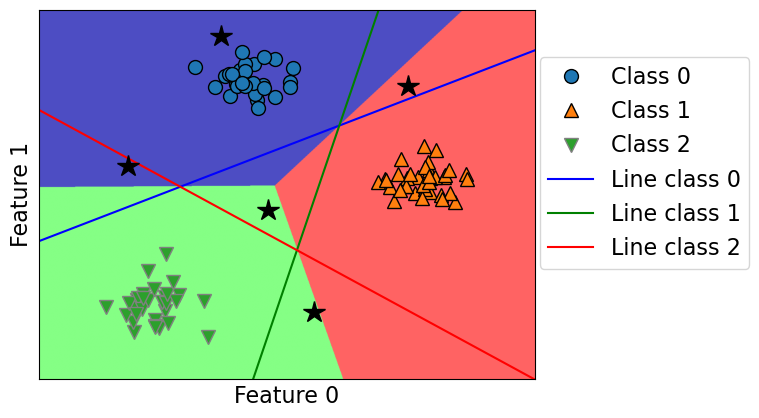

In [7]:
plot_multiclass_lr_ovr(lr, X_train, y_train, 3, test_points, decision_boundary=True)

Let's calculate the raw scores for a test point. 

In [8]:
test_points[4]

[0, -7]

In [9]:
lr.coef_

array([[-0.65125032,  1.05350962],
       [ 1.35375221, -0.2865025 ],
       [-0.63316788, -0.7250894 ]])

In [10]:
lr.intercept_ 

array([-5.42541681,  0.21616484, -2.47242662])

In [11]:
test_points[4]@lr.coef_.T + lr.intercept_

array([-12.79998417,   2.22168237,   2.60319915])

In [12]:
lr.classes_

array([0, 1, 2])

Class 1 and 2 seems to have similar scores, which makes sense because the point is close to the border. But it's in the green region because Class 2 score is the highest. 

In [13]:
lr.predict_proba([test_points[4]])

array([[1.50596432e-06, 4.92120500e-01, 5.07877994e-01]])

### One Vs. One approach 

- Build a binary model for each pair of classes.
- 1v2, 1v3, 2v3
- Trains n * (n-1)/2 binary classifiers
- Trained on relatively balanced subsets

### One Vs. One prediction

- Apply all of the classifiers on the test example.
- Count how often each class was predicted.  
- Predict the class with most votes. 

### Using OVR and OVO as wrappers

- You can use these strategies as meta-strategies for any binary classifiers. 
    - [`OneVsRestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)
    - [`OneVsOneClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

- When do we use  `OneVsRestClassifier` and ``OneVsOneClassifier``
- It's not that likely for you to need `OneVsRestClassifier` or `OneVsOneClassifier` because most of the methods you'll use will have native multi-class support. 
- However, it's good to know in case you ever need to extend a binary classifier (perhaps one you've implemented on your own).

In [14]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

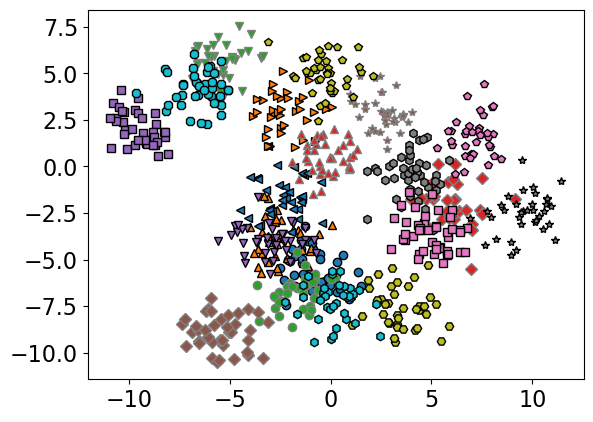

In [15]:
# Let's examine the time taken by OneVsRestClassifier and OneVsOneClassifier

# generate blobs with fixed random generator
X_multi, y_multi = make_blobs(n_samples=1000, centers=20, random_state=300)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi
)

mglearn.discrete_scatter(X_train_multi[:, 0], X_train_multi[:, 1], y_train_multi, s=6);

In [16]:
model = OneVsOneClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVO wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

165 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVO wrapper
0.792
0.78


In [17]:
model = OneVsRestClassifier(LogisticRegression())
%timeit model.fit(X_train_multi, y_train_multi);
print("With OVR wrapper")
print(model.score(X_train_multi, y_train_multi))
print(model.score(X_test_multi, y_test_multi))

24.3 ms ± 810 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
With OVR wrapper
0.736
0.716


- As expected OVO takes more time compared to OVR
- [Here](https://scikit-learn.org/stable/modules/multiclass.html) you will find summary of how `scikit-learn` handles multi-class classification for different classifiers. 